**importing the libraries**

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

**loading the original data**

In [ ]:
df = pd.read_csv('/content/rnn_dataset.csv')

In [ ]:
df.columns

Index(['Datetime', 'PJMW_MW'], dtype='object')

In [ ]:
#df['Datetime] = df.set_index('Datetime').sort_index()
#df.set_index('Datetime', inplace = True)
df=df.sort_values(by=['Datetime'])
df

,Datetime,PJMW_MW
6574,2002-04-01 01:00:00,4374.0
6575,2002-04-01 02:00:00,4306.0
6576,2002-04-01 03:00:00,4322.0
6577,2002-04-01 04:00:00,4359.0
6578,2002-04-01 05:00:00,4436.0
...,...,...
138090,2018-08-02 20:00:00,6545.0
138091,2018-08-02 21:00:00,6496.0
138092,2018-08-02 22:00:00,6325.0
138093,2018-08-02 23:00:00,5892.0


In [ ]:
df.columns

Index(['Datetime', 'PJMW_MW'], dtype='object')

**modifying the original data to add more features as given:  hour, day, day of the week, week of the year information, as
well as the periodicity information, along with checking whether the day is a holiday using the holiday module as
features**

In [ ]:
df['hour'] = pd.to_datetime(df['Datetime']).dt.hour

In [ ]:
df

,Datetime,PJMW_MW,hour
6574,2002-04-01 01:00:00,4374.0,1
6575,2002-04-01 02:00:00,4306.0,2
6576,2002-04-01 03:00:00,4322.0,3
6577,2002-04-01 04:00:00,4359.0,4
6578,2002-04-01 05:00:00,4436.0,5
...,...,...,...
138090,2018-08-02 20:00:00,6545.0,20
138091,2018-08-02 21:00:00,6496.0,21
138092,2018-08-02 22:00:00,6325.0,22
138093,2018-08-02 23:00:00,5892.0,23


In [ ]:
df['day'] = pd.to_datetime(df['Datetime']).dt.day

In [ ]:
df['date'] = pd.to_datetime(df['Datetime']).dt.date

In [ ]:
df

,Datetime,PJMW_MW,hour,day,date
6574,2002-04-01 01:00:00,4374.0,1,1,2002-04-01
6575,2002-04-01 02:00:00,4306.0,2,1,2002-04-01
6576,2002-04-01 03:00:00,4322.0,3,1,2002-04-01
6577,2002-04-01 04:00:00,4359.0,4,1,2002-04-01
6578,2002-04-01 05:00:00,4436.0,5,1,2002-04-01
...,...,...,...,...,...
138090,2018-08-02 20:00:00,6545.0,20,2,2018-08-02
138091,2018-08-02 21:00:00,6496.0,21,2,2018-08-02
138092,2018-08-02 22:00:00,6325.0,22,2,2018-08-02
138093,2018-08-02 23:00:00,5892.0,23,2,2018-08-02


In [ ]:
df['weekday'] = pd.to_datetime(df['Datetime']).dt.weekday

In [ ]:
df['weekday'][63330]

6

In [ ]:
df['weekyear'] = pd.to_datetime(df['Datetime']).dt.isocalendar().week

In [ ]:
df['weekyear'][5555]

20

In [ ]:
autocorr = df['PJMW_MW'].autocorr(lag=1) # replace 1 with the desired lag
print(f"Autocorrelation at lag 1: {autocorr}")

Autocorrelation at lag 1: 0.9746791642158641


In [ ]:
import statsmodels.api as sm
# Compute the autocorrelation function
acf = sm.tsa.stattools.acf(df['PJMW_MW'], nlags=len(df)-1)

# Find the lag at which the autocorrelation drops below 0.96
lag = np.argmax(acf < 0.96)

# Create a new column for the periodicity information
df['periodicity'] = pd.Series(np.zeros(len(df)))
df['periodicity'].iloc[lag::lag] = 1

<ipython-input-18-ab22bfd98f9c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['periodicity'].iloc[lag::lag] = 1


In [ ]:
df

,Datetime,PJMW_MW,hour,day,date,weekday,weekyear,periodicity
6574,2002-04-01 01:00:00,4374.0,1,1,2002-04-01,0,14,0.0
6575,2002-04-01 02:00:00,4306.0,2,1,2002-04-01,0,14,0.0
6576,2002-04-01 03:00:00,4322.0,3,1,2002-04-01,0,14,1.0
6577,2002-04-01 04:00:00,4359.0,4,1,2002-04-01,0,14,0.0
6578,2002-04-01 05:00:00,4436.0,5,1,2002-04-01,0,14,1.0
...,...,...,...,...,...,...,...,...
138090,2018-08-02 20:00:00,6545.0,20,2,2018-08-02,3,31,0.0
138091,2018-08-02 21:00:00,6496.0,21,2,2018-08-02,3,31,1.0
138092,2018-08-02 22:00:00,6325.0,22,2,2018-08-02,3,31,0.0
138093,2018-08-02 23:00:00,5892.0,23,2,2018-08-02,3,31,1.0


In [ ]:
df['year'] = pd.to_datetime(df['Datetime']).dt.year

In [ ]:
df

,Datetime,PJMW_MW,hour,day,date,weekday,weekyear,periodicity,year
6574,2002-04-01 01:00:00,4374.0,1,1,2002-04-01,0,14,0.0,2002
6575,2002-04-01 02:00:00,4306.0,2,1,2002-04-01,0,14,0.0,2002
6576,2002-04-01 03:00:00,4322.0,3,1,2002-04-01,0,14,1.0,2002
6577,2002-04-01 04:00:00,4359.0,4,1,2002-04-01,0,14,0.0,2002
6578,2002-04-01 05:00:00,4436.0,5,1,2002-04-01,0,14,1.0,2002
...,...,...,...,...,...,...,...,...,...
138090,2018-08-02 20:00:00,6545.0,20,2,2018-08-02,3,31,0.0,2018
138091,2018-08-02 21:00:00,6496.0,21,2,2018-08-02,3,31,1.0,2018
138092,2018-08-02 22:00:00,6325.0,22,2,2018-08-02,3,31,0.0,2018
138093,2018-08-02 23:00:00,5892.0,23,2,2018-08-02,3,31,1.0,2018


In [ ]:
df['month'] = pd.to_datetime(df['Datetime']).dt.month

In [ ]:
df

,Datetime,PJMW_MW,hour,day,date,weekday,weekyear,periodicity,year,month
6574,2002-04-01 01:00:00,4374.0,1,1,2002-04-01,0,14,0.0,2002,4
6575,2002-04-01 02:00:00,4306.0,2,1,2002-04-01,0,14,0.0,2002,4
6576,2002-04-01 03:00:00,4322.0,3,1,2002-04-01,0,14,1.0,2002,4
6577,2002-04-01 04:00:00,4359.0,4,1,2002-04-01,0,14,0.0,2002,4
6578,2002-04-01 05:00:00,4436.0,5,1,2002-04-01,0,14,1.0,2002,4
...,...,...,...,...,...,...,...,...,...,...
138090,2018-08-02 20:00:00,6545.0,20,2,2018-08-02,3,31,0.0,2018,8
138091,2018-08-02 21:00:00,6496.0,21,2,2018-08-02,3,31,1.0,2018,8
138092,2018-08-02 22:00:00,6325.0,22,2,2018-08-02,3,31,0.0,2018,8
138093,2018-08-02 23:00:00,5892.0,23,2,2018-08-02,3,31,1.0,2018,8


In [ ]:
!pip install holidays
import holidays
from datetime import date


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

# Get a list of holidays for the USA in the year 2022
for i in range(0,143206):
  #print(i)
  _holidays = holidays.India()
  date_to_check = date(df['year'][i], df['month'][i], df['day'][i])
# Check if a date is a holiday
#date_to_check = date(2022, 7, 4)  # July 4, 2022
#is_holiday = my_date in india_holidays
  if date_to_check in _holidays:
    df['holiday']=0
  else:
    df['holiday']=1


In [ ]:
df  #remove date, year, month

,Datetime,PJMW_MW,hour,day,date,weekday,weekyear,periodicity,year,month,holiday
6574,2002-04-01 01:00:00,4374.0,1,1,2002-04-01,0,14,0.0,2002,4,1
6575,2002-04-01 02:00:00,4306.0,2,1,2002-04-01,0,14,0.0,2002,4,1
6576,2002-04-01 03:00:00,4322.0,3,1,2002-04-01,0,14,1.0,2002,4,1
6577,2002-04-01 04:00:00,4359.0,4,1,2002-04-01,0,14,0.0,2002,4,1
6578,2002-04-01 05:00:00,4436.0,5,1,2002-04-01,0,14,1.0,2002,4,1
...,...,...,...,...,...,...,...,...,...,...,...
138090,2018-08-02 20:00:00,6545.0,20,2,2018-08-02,3,31,0.0,2018,8,1
138091,2018-08-02 21:00:00,6496.0,21,2,2018-08-02,3,31,1.0,2018,8,1
138092,2018-08-02 22:00:00,6325.0,22,2,2018-08-02,3,31,0.0,2018,8,1
138093,2018-08-02 23:00:00,5892.0,23,2,2018-08-02,3,31,1.0,2018,8,1


In [ ]:
# assume holidays are weekends
df['Holiday'] = (df['weekday'] == 5) | (df['weekday'] == 6)
df

,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday,Holiday
6574,4374.0,1,1,0,14,0.0,1,False
6575,4306.0,2,1,0,14,0.0,1,False
6576,4322.0,3,1,0,14,1.0,1,False
6577,4359.0,4,1,0,14,0.0,1,False
6578,4436.0,5,1,0,14,1.0,1,False
...,...,...,...,...,...,...,...,...
138090,6545.0,20,2,3,31,0.0,1,False
138091,6496.0,21,2,3,31,1.0,1,False
138092,6325.0,22,2,3,31,0.0,1,False
138093,5892.0,23,2,3,31,1.0,1,False


In [ ]:
for i in range(0,143206):
  if df['Holiday'][i]==False:
    df['holiday'][i]=0
  else:
    df['holiday'][i]=1

<ipython-input-30-d7bf2426517a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['holiday'][i]=0
<ipython-input-30-d7bf2426517a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['holiday'][i]=1


In [ ]:
df

,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday,Holiday
6574,4374.0,1,1,0,14,0.0,0,False
6575,4306.0,2,1,0,14,0.0,0,False
6576,4322.0,3,1,0,14,1.0,0,False
6577,4359.0,4,1,0,14,0.0,0,False
6578,4436.0,5,1,0,14,1.0,0,False
...,...,...,...,...,...,...,...,...
138090,6545.0,20,2,3,31,0.0,0,False
138091,6496.0,21,2,3,31,1.0,0,False
138092,6325.0,22,2,3,31,0.0,0,False
138093,5892.0,23,2,3,31,1.0,0,False


In [ ]:
for i in range(0, 143206):
  if df['holiday'][i]==1:
    print(i)
    break

48


In [ ]:
df = df.drop(['date', 'year', 'month'], axis = 1)


In [ ]:
df = df.drop(['Datetime'], axis = 1)
df

,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday
6574,4374.0,1,1,0,14,0.0,1
6575,4306.0,2,1,0,14,0.0,1
6576,4322.0,3,1,0,14,1.0,1
6577,4359.0,4,1,0,14,0.0,1
6578,4436.0,5,1,0,14,1.0,1
...,...,...,...,...,...,...,...
138090,6545.0,20,2,3,31,0.0,1
138091,6496.0,21,2,3,31,1.0,1
138092,6325.0,22,2,3,31,0.0,1
138093,5892.0,23,2,3,31,1.0,1


In [ ]:
df['weekday'][48]

6

In [ ]:
#holiday =1
df

,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday,Holiday
6574,4374.0,1,1,0,14,0.0,0,False
6575,4306.0,2,1,0,14,0.0,0,False
6576,4322.0,3,1,0,14,1.0,0,False
6577,4359.0,4,1,0,14,0.0,0,False
6578,4436.0,5,1,0,14,1.0,0,False
...,...,...,...,...,...,...,...,...
138090,6545.0,20,2,3,31,0.0,0,False
138091,6496.0,21,2,3,31,1.0,0,False
138092,6325.0,22,2,3,31,0.0,0,False
138093,5892.0,23,2,3,31,1.0,0,False


In [ ]:
df= df.drop(['Holiday'], axis = 1)
df

,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday
6574,4374.0,1,1,0,14,0.0,0
6575,4306.0,2,1,0,14,0.0,0
6576,4322.0,3,1,0,14,1.0,0
6577,4359.0,4,1,0,14,0.0,0
6578,4436.0,5,1,0,14,1.0,0
...,...,...,...,...,...,...,...
138090,6545.0,20,2,3,31,0.0,0
138091,6496.0,21,2,3,31,1.0,0
138092,6325.0,22,2,3,31,0.0,0
138093,5892.0,23,2,3,31,1.0,0


**downloading the obtained modified dataset**

In [ ]:
from google.colab import files

df.to_csv('df5.csv')
files.download('df5.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**loading the modified dataset**

In [2]:
df2 = pd.read_csv('/content/df5.csv')
df2

,Unnamed: 0,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday
0,6574,4374.0,1,1,0,14,0.0,0
1,6575,4306.0,2,1,0,14,0.0,0
2,6576,4322.0,3,1,0,14,1.0,0
3,6577,4359.0,4,1,0,14,0.0,0
4,6578,4436.0,5,1,0,14,1.0,0
...,...,...,...,...,...,...,...,...
143201,138090,6545.0,20,2,3,31,0.0,0
143202,138091,6496.0,21,2,3,31,1.0,0
143203,138092,6325.0,22,2,3,31,0.0,0
143204,138093,5892.0,23,2,3,31,1.0,0


In [3]:
df2 = df2.drop(['Unnamed: 0'], axis=1)
df2

,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday
0,4374.0,1,1,0,14,0.0,0
1,4306.0,2,1,0,14,0.0,0
2,4322.0,3,1,0,14,1.0,0
3,4359.0,4,1,0,14,0.0,0
4,4436.0,5,1,0,14,1.0,0
...,...,...,...,...,...,...,...
143201,6545.0,20,2,3,31,0.0,0
143202,6496.0,21,2,3,31,1.0,0
143203,6325.0,22,2,3,31,0.0,0
143204,5892.0,23,2,3,31,1.0,0


In [4]:
#input = 6 columns: target = pjmw_mw
target = df2['PJMW_MW'].values
df2['PJMW_MW'] = (target - target.mean()) / target.std()

In [5]:
df2

,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday
0,-1.254546,1,1,0,14,0.0,0
1,-1.323994,2,1,0,14,0.0,0
2,-1.307653,3,1,0,14,1.0,0
3,-1.269865,4,1,0,14,0.0,0
4,-1.191225,5,1,0,14,1.0,0
...,...,...,...,...,...,...,...
143201,0.962708,20,2,3,31,0.0,0
143202,0.912664,21,2,3,31,1.0,0
143203,0.738020,22,2,3,31,0.0,0
143204,0.295795,23,2,3,31,1.0,0


In [6]:
# Set hyperparameters
seq_len = 100
input_size = 7
hidden_size = 32
output_size = 1
learning_rate = 0.0001
num_epochs = 10

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
def data_form(target, seq_len):
  data = target[:(len(target) - seq_len)]
  train, test = train_test_split(data, test_size = 0.3, random_state=24, shuffle= False)
  val, test1 = train_test_split(test, test_size = 0.5, random_state=24, shuffle= False)
  return train,val,test1

In [9]:
train_data, val_data, test_data = data_form(df2, 100)

In [10]:
df2

,PJMW_MW,hour,day,weekday,weekyear,periodicity,holiday
0,-1.254546,1,1,0,14,0.0,0
1,-1.323994,2,1,0,14,0.0,0
2,-1.307653,3,1,0,14,1.0,0
3,-1.269865,4,1,0,14,0.0,0
4,-1.191225,5,1,0,14,1.0,0
...,...,...,...,...,...,...,...
143201,0.962708,20,2,3,31,0.0,0
143202,0.912664,21,2,3,31,1.0,0
143203,0.738020,22,2,3,31,0.0,0
143204,0.295795,23,2,3,31,1.0,0


In [11]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

**splitting the dataset in train, validation, test dataset into 70%, 15%, 15%**

In [12]:
# split data into train, validation, and test sets
train_size = int(0.7 * len(df2))
val_size = int(0.15 * len(df2))
test_size = len(df2) - train_size - val_size

train_df = df2.iloc[:train_size]
val_df = df2.iloc[train_size:train_size+val_size]
test_df = df2.iloc[train_size+val_size:]

# normalize data
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

# create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 100

train_data = train_df.values.astype(np.float32)
val_data = val_df.values.astype(np.float32)
test_data = test_df.values.astype(np.float32)

train_X, train_y = create_sequences(train_data, seq_length)
val_X, val_y = create_sequences(val_data, seq_length)
test_X, test_y = create_sequences(test_data, seq_length)

train_X = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_y)
val_X = torch.from_numpy(val_X)
val_y = torch.from_numpy(val_y)
test_X = torch.from_numpy(test_X)
test_y = torch.from_numpy(test_y)

In [13]:
from torch.utils.data import TensorDataset, DataLoader
batch_size = 64
train = TensorDataset(train_X, train_y)
val = TensorDataset(val_X, val_y)
test = TensorDataset(test_X, test_y)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)


In [14]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim): #dropout_prob):
        """The __init__ method that initiates an RNN instance.

        Args:
            input_dim (int): The number of nodes in the input layer
            hidden_dim (int): The number of nodes in each layer
            layer_dim (int): The number of layers in the network
            output_dim (int): The number of nodes in the output layer
            dropout_prob (float): The probability of nodes being dropped out

        """
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True) #dropout=dropout_prob
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """The forward method takes input tensor x and does forward propagation

        Args:
            x (torch.Tensor): The input tensor of the shape (batch size, sequence length, input_dim)

        Returns:
            torch.Tensor: The output tensor of the shape (batch size, output_dim)

        """
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim,device=x.device).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [15]:
class Optimization:
    """Optimization is a helper class that allows training, validation, prediction.

    Optimization is a helper class that takes model, loss function, optimizer function
    learning scheduler (optional), early stopping (optional) as inputs. In return, it
    provides a framework to train and validate the models, and to predict future values
    based on the models.

    Attributes:
        model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
        loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
        optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        train_losses (list[float]): The loss values from the training
        val_losses (list[float]): The loss values from the validation
        last_epoch (int): The number of epochs that the models is trained
    """
    def __init__(self, model, loss_fn, optimizer):
        """
        Args:
            model (RNNModel, LSTMModel, GRUModel): Model class created for the type of RNN
            loss_fn (torch.nn.modules.Loss): Loss function to calculate the losses
            optimizer (torch.optim.Optimizer): Optimizer function to optimize the loss function
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
        
    def train_step(self, x, y):
        """The method train_step completes one step of training.

        Given the features (x) and the target values (y) tensors, the method completes
        one step of the training. First, it activates the train mode to enable back prop.
        After generating predicted values (yhat) by doing forward propagation, it calculates
        the losses by using the loss function. Then, it computes the gradients by doing
        back propagation and updates the weights by calling step() function.

        Args:
            x (torch.Tensor): Tensor for features to train one step
            y (torch.Tensor): Tensor for target values to calculate losses

        """
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """The method train performs the model training

        The method takes DataLoaders for training and validation datasets, batch size for
        mini-batch training, number of epochs to train, and number of features as inputs.
        Then, it carries out the training by iteratively calling the method train_step for
        n_epochs times. If early stopping is enabled, then it  checks the stopping condition
        to decide whether the training needs to halt before n_epochs steps. Finally, it saves
        the model in a designated file path.

        Args:
            train_loader (torch.utils.data.DataLoader): DataLoader that stores training data
            val_loader (torch.utils.data.DataLoader): DataLoader that stores validation data
            batch_size (int): Batch size for mini-batch training
            n_epochs (int): Number of epochs, i.e., train steps, to train
            n_features (int): Number of feature columns

        """#/content/df5.csv
        #model_path = f'{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'
        #model_path = F'/content/'
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 20 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), 'checkpoint.pth') #model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """The method evaluate performs the model evaluation

        The method takes DataLoaders for the test dataset, batch size for mini-batch testing,
        and number of features as inputs. Similar to the model validation, it iteratively
        predicts the target values and calculates losses. Then, it returns two lists that
        hold the predictions and the actual values.

        Note:
            This method assumes that the prediction from the previous step is available at
            the time of the prediction, and only does one-step prediction into the future.

        Args:
            test_loader (torch.utils.data.DataLoader): DataLoader that stores test data
            batch_size (int): Batch size for mini-batch training
            n_features (int): Number of feature columns

        Returns:
            list[float]: The values predicted by the model
            list[float]: The actual values in the test set.

        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                yhat=yhat.cpu().data.numpy()
                predictions.append(yhat)
                y_test=y_test.cpu().data.numpy()
                values.append(y_test)

        return predictions, values
    
    def plot_losses(self):
        """The method plots the calculated loss values for training and validation
        """
        plt.style.use('ggplot')
        plt.figure(figsize=(10,5))
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

In [23]:
import torch.optim as optim
def General_Settings(model_name):

        input_dim = 7 #len(train_X.columns)
        output_dim = 1
        hidden_dim = 64
        layer_dim = 1
        batch_size = 64
        #dropout = 0.2
        n_epochs = 10
        learning_rate = 1e-4
        #weight_decay = 1e-6

        model_params = {'input_dim': input_dim,
                        'hidden_dim' : hidden_dim,
                        'layer_dim' : layer_dim,
                        'output_dim' : output_dim}
                        #'dropout_prob' : dropout}
        model = get_model(model_name, model_params)
        loss_fn = nn.MSELoss(reduction="mean")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate) #weight_decay=weight_decay)

        opt = Optimization(model=model.to(device), loss_fn=loss_fn, optimizer=optimizer)
        opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
        opt.plot_losses()

        predictions, values = opt.evaluate(
            test_loader_one,
            batch_size=1,
            n_features=input_dim
        )
        return predictions,values

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [25]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    #df_result = pd.DataFrame(data={"value": vals, "prediction": preds}) #index=test_data.head(len(vals)).index)
    #df_result = df_result.sort_index()
    #df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return vals, preds

In [26]:

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(true, preds):
    #true, preds = df
    result_metrics = {'mae' : mean_absolute_error(true, preds),
                      'rmse' : mean_squared_error(true, preds) ** 0.5,
                      'r2' : r2_score(true, preds)}
    
    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

In [27]:
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
       # "lstm": LSTMModel,
       # "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**training and plotting the loss curves**

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/10] Training loss: 0.8524	 Validation loss: 0.9031
[2/10] Training loss: 0.8380	 Validation loss: 0.8962
[3/10] Training loss: 0.8335	 Validation loss: 0.8944
[4/10] Training loss: 0.8320	 Validation loss: 0.8934
[5/10] Training loss: 0.8311	 Validation loss: 0.8927
[6/10] Training loss: 0.8304	 Validation loss: 0.8923
[7/10] Training loss: 0.8300	 Validation loss: 0.8916
[8/10] Training loss: 0.8297	 Validation loss: 0.8916
[9/10] Training loss: 0.8295	 Validation loss: 0.8915
[10/10] Training loss: 0.8293	 Validation loss: 0.8913


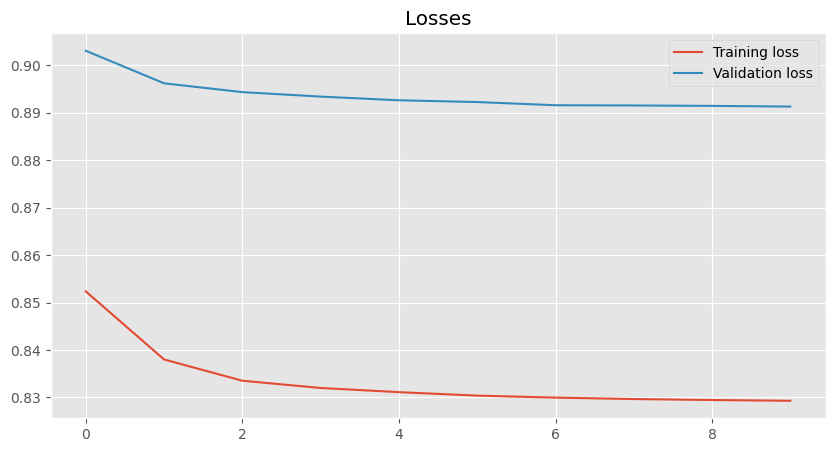

In [29]:
model_name='rnn'
predictions, values=General_Settings(model_name)
true, preds=format_predictions(predictions, values, test_X, scaler)
#print(calculate_metrics(values, predictions))

In [30]:
values[0][0][0]

-0.4465192

In [31]:
vals = [values[i][0][0] for i in range(len(values))]
#vals

In [32]:
preds = np.concatenate(predictions, axis=0).ravel()
preds

array([-0.31159467, -0.5980188 , -0.30254105, ...,  0.18509197,
       -0.0943229 ,  0.16866791], dtype=float32)

**comparing the actual or true values and predicted values**

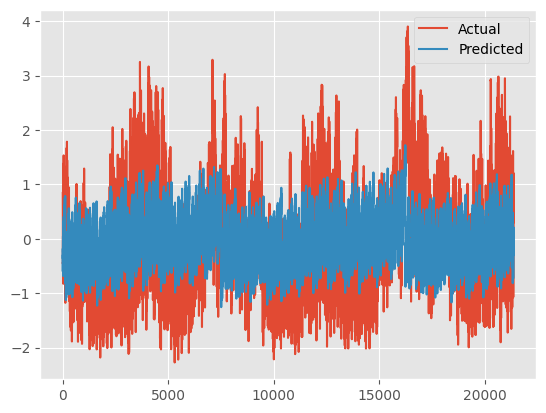

In [34]:
plt.plot(vals, label='Actual')
plt.plot(preds, label='Predicted')
plt.legend()
plt.show()

**calculating the performance metrics**

In [33]:
print(calculate_metrics(vals, preds))

Mean Absolute Error:        0.766042
Root Mean Squared Error:    0.9657547082788699
R^2 Score:                  0.12123544900033845
{'mae': 0.766042, 'rmse': 0.9657547082788699, 'r2': 0.12123544900033845}


##observations##

1. When considering only one feature as mentioned in part 1 of this assignment, the plot of actual or true test data values and predictions of the same by the model in the part 1, it can be obeserved that the overlap between the two was very less and had a huge difference.

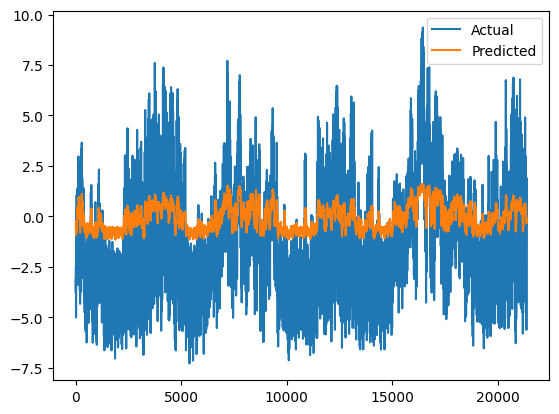

2. On the other hand, the same plot in case of part 2 of this assignment showed better overlap between the actual and predicted values.

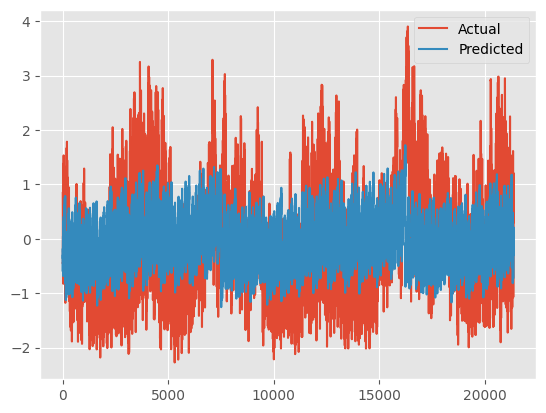

3. The performance metrics for the part 1 of the assignment were:
  
  Mean Absolute Error:        2.169836564704385

  Root Mean Squared Error:    2.6202700018605825

  R^2 Score:                  0.10862865102629382

  {'mae': 2.169836564704385, 'rmse': 2.6202700018605825, 'r2': 0.10862865102629382}
4. The performance metrics for the part 2 of the assignment were:

  Mean Absolute Error:        0.766042
  
  Root Mean Squared Error:    0.9657547082788699
  
  R^2 Score:                  0.12123544900033845
  
  {'mae': 0.766042, 'rmse': 0.9657547082788699, 'r2': 0.12123544900033845}
5. Thus, it can be seen that the RNN with more number of features as in part 2 of the assignment, showed better performance than RNN in part 1 of the assignment. 